# Example: Stimuli analysis for pupil diameter luminance correction in CEAP-360VR 

This notebook loads and preprocesses the stimuli videos in the dataset `CEAP-360VR` [GitHub repo](https://github.com/luiseduve/CEAP-360VR-Dataset) to calculate the luminance per frame for the pupil diameter (PD) correction:

*CEAP-360VR: A Continuous Physiological and Behavioral Emotion Annotation Dataset for 360 VR Videos* [(DOI)](10.1109/TMM.2021.3124080)

*Description:* 

1. Attach the starting offset and number of frames to the VideoInfo
2. Load the video frame-by-frame and extract the average luminosity with OpenCV
3. Store the luminance values in a file `VideoLuminance.csv`
4. Apply the correction from luminance when loading the data in the parameter `clean_pd_with_luminance`

In [3]:
# Add files to sys.path
from pathlib import Path
import sys, os, json
this_path = None
try:    # WORKS WITH .py
    this_path = str(os.path.dirname(os.path.abspath(__file__)))
except: # WORKS WITH .ipynb
    this_path = str(Path().absolute())+"/" 
print("File Path:", this_path)

File Path: e:\dsv\datasets\0_CEAP\CEAP-360VR-Dataset\CEAP-360VR\6_Scripts\4_Example Jupyter Notebook/


In [4]:
import ceap_loader

import os

# Libs for data manipulation
import numpy as np
import pandas as pd

# Video analysis
import cv2

# Visualization
import matplotlib.pyplot as plt

---
## Setup

In [5]:
# All the files generated from this notebook are in a subfolder with this name
STR_DATASET = "ceap_example/"

In [6]:
def gen_path_temp(filename, subfolders="", extension=".csv"):
    # Function to generate temporary files easier
    TEMP_FOLDER_NAME = "./temp/"
    return ceap_loader.generate_complete_path(filename, \
                                        main_folder=TEMP_FOLDER_NAME, \
                                        subfolders=STR_DATASET+subfolders, \
                                        file_extension=extension)

---
# 1) Loading the dataset as CSV
---

In [7]:
# Define the root folder of the dataset with respect to the notebook
dataset_root_folder = "../../../CEAP-360VR/"
print(dataset_root_folder)

../../../CEAP-360VR/


The class `DatasetCEAP()` generates three files in the same folder of the dataset:
1. `data_tree_index.json`: The index containing the relative paths of the data files, grouped per data type (*Annotations, Behavior, Physio*), processing level (*Raw, Transformed, Frame*) and participant (*From 1 to 32*).
2. `demographics_info_summary.csv`: A table that summarizes, per participant, the demographic information, subjective ratings from the questionnaires, and when the participant watched each of the 8 stimuli videos.
3. `video_info_summary.csv`: A table describing the metadata from the video as in the folder `1_Stimuli`.

In [8]:
data_manager = ceap_loader.DatasetCEAP(dataset_root_folder)

Index already exists: Loading from  ../../../CEAP-360VR/data_tree_index.json


In [9]:
# Access the stimuli data
data_manager.stimuli

,VideoID,VideoFileName,VideoResolutionWidth,VideoResolutionHeight,VideoDuration,FrameRate,FrameCount,VideoLink,OriginalValence,OriginalArousal,PilotStudyValence,PilotStudyArousal
0,V0,NASA: Encapsulation & Launch of OSIRIS Rex,3840,2048,60,30,1816,D7-AmamuJEA,6.36,5.93,0.00,0.00
1,V1,Puppies host SourceFed for a day,3840,1920,60,25,1501,c7sA3EdXSUQ,7.47,5.35,7.08,6.08
2,V2,Mountain Stillness,3840,1920,60,30,1801,aePXpV8Z10Y,6.13,1.80,8.08,1.92
3,V3,Zombie Apocalypse Horror,3840,1920,59,30,1795,pHX3U4B6BCk,3.20,5.60,2.58,6.83
4,V4,War Zone,3840,2048,60,30,1803,Nxxb_7wzvJI,2.53,3.82,2.42,4.17
5,V5,Speed Flying,3840,1920,60,30,1801,g6w6xkQeSHg,6.75,7.42,6.83,7.42
6,V6,Malaekahana Sunrise,3840,1920,60,30,1801,-bIrUYM-GjU,6.57,1.57,7.67,1.50
7,V7,Jailbreak 360,3840,2048,60,30,1801,vNLDRSdAj1U,4.40,6.70,4.42,7.17
8,V8,The Nepal Earthquake Aftermath,3840,2048,60,30,1801,5tasUGQ1898,2.73,3.80,2.17,3.17


## Add the offset according to paper

In [10]:
videos_info = data_manager.stimuli
videos_info

,VideoID,VideoFileName,VideoResolutionWidth,VideoResolutionHeight,VideoDuration,FrameRate,FrameCount,VideoLink,OriginalValence,OriginalArousal,PilotStudyValence,PilotStudyArousal
0,V0,NASA: Encapsulation & Launch of OSIRIS Rex,3840,2048,60,30,1816,D7-AmamuJEA,6.36,5.93,0.00,0.00
1,V1,Puppies host SourceFed for a day,3840,1920,60,25,1501,c7sA3EdXSUQ,7.47,5.35,7.08,6.08
2,V2,Mountain Stillness,3840,1920,60,30,1801,aePXpV8Z10Y,6.13,1.80,8.08,1.92
3,V3,Zombie Apocalypse Horror,3840,1920,59,30,1795,pHX3U4B6BCk,3.20,5.60,2.58,6.83
4,V4,War Zone,3840,2048,60,30,1803,Nxxb_7wzvJI,2.53,3.82,2.42,4.17
5,V5,Speed Flying,3840,1920,60,30,1801,g6w6xkQeSHg,6.75,7.42,6.83,7.42
6,V6,Malaekahana Sunrise,3840,1920,60,30,1801,-bIrUYM-GjU,6.57,1.57,7.67,1.50
7,V7,Jailbreak 360,3840,2048,60,30,1801,vNLDRSdAj1U,4.40,6.70,4.42,7.17
8,V8,The Nepal Earthquake Aftermath,3840,2048,60,30,1801,5tasUGQ1898,2.73,3.80,2.17,3.17


In [11]:
video_start_offset = pd.DataFrame(data= [7, 0, 10, 65, 3, 0, 0, 127, 41], index=videos_info.index, columns=["StartOffset"])
video_start_offset

,StartOffset
0,7
1,0
2,10
3,65
4,3
5,0
6,0
7,127
8,41


In [12]:
videos_info = videos_info.join(video_start_offset)
videos_info

,VideoID,VideoFileName,VideoResolutionWidth,VideoResolutionHeight,VideoDuration,FrameRate,FrameCount,VideoLink,OriginalValence,OriginalArousal,PilotStudyValence,PilotStudyArousal,StartOffset
0,V0,NASA: Encapsulation & Launch of OSIRIS Rex,3840,2048,60,30,1816,D7-AmamuJEA,6.36,5.93,0.00,0.00,7
1,V1,Puppies host SourceFed for a day,3840,1920,60,25,1501,c7sA3EdXSUQ,7.47,5.35,7.08,6.08,0
2,V2,Mountain Stillness,3840,1920,60,30,1801,aePXpV8Z10Y,6.13,1.80,8.08,1.92,10
3,V3,Zombie Apocalypse Horror,3840,1920,59,30,1795,pHX3U4B6BCk,3.20,5.60,2.58,6.83,65
4,V4,War Zone,3840,2048,60,30,1803,Nxxb_7wzvJI,2.53,3.82,2.42,4.17,3
5,V5,Speed Flying,3840,1920,60,30,1801,g6w6xkQeSHg,6.75,7.42,6.83,7.42,0
6,V6,Malaekahana Sunrise,3840,1920,60,30,1801,-bIrUYM-GjU,6.57,1.57,7.67,1.50,0
7,V7,Jailbreak 360,3840,2048,60,30,1801,vNLDRSdAj1U,4.40,6.70,4.42,7.17,127
8,V8,The Nepal Earthquake Aftermath,3840,2048,60,30,1801,5tasUGQ1898,2.73,3.80,2.17,3.17,41


## Process a file given a path and the video ID


In [13]:
def calculate_luminosity_from_video_file(index_filename:str, video_filepath:str, preview_videos = True):
    """
    Takes a video filename and process it to extract
    video features, load frames, and extract luminance
    values per frame.
    """

    ### Video information
    cv2video = cv2.VideoCapture( video_filepath )
    height = cv2video.get(cv2.CAP_PROP_FRAME_HEIGHT)
    width  = cv2video.get(cv2.CAP_PROP_FRAME_WIDTH) 
    frames_per_sec = cv2video.get(cv2.CAP_PROP_FPS)
    framecount = cv2video.get(cv2.CAP_PROP_FRAME_COUNT ) 
    total_frames = cv2video.get(cv2.CAP_PROP_FRAME_COUNT)

    video_name = videos_info.loc[index_filename,"VideoFileName"]
    v_offset_s = videos_info.loc[index_filename,"StartOffset"]
    v_num_frames = videos_info.loc[index_filename,"FrameCount"]

    print(f"Video Info: {video_name} - [{width}x{height}] @ {frames_per_sec} FPS")
    print(f"\t Offset (s): {v_offset_s} \t\t Frames to process (N): {v_num_frames}")
    
    first_frame_index = int(frames_per_sec * v_offset_s)
    last_frame_index = int(first_frame_index + v_num_frames)
    
    print(f"\t Frames to process: [{first_frame_index},{last_frame_index}] / {total_frames}")
    ### Load specific frames from the video

    # Iterate over all video frames
    # (it needs to be from the beginning because videos are encoded
    #  and apparently cannot jump to specific frames without losing data)

    # Display the video when processing
    if(preview_videos):
        cv2.namedWindow(f'{video_name}', cv2.WINDOW_NORMAL)

    # Results with luminance per frame
    results_luminance = None
    
    for i in range(int(total_frames)):
        # Read current frame and elapsed time
        current_frame = cv2video.get(cv2.CAP_PROP_POS_FRAMES)
        elapsed_time_ms = cv2video.get(cv2.CAP_PROP_POS_MSEC)

        # Retrieve the video and check if there are errors
        ret, frame = cv2video.read()
        if not ret:
            print(f"Error loading frame. t={elapsed_time_ms}. f={current_frame}")
            continue
        
        # Stop if all relevant frames are retrieved
        if(current_frame >= last_frame_index):
            break

        # Just process the frames within range
        if ( (current_frame >= first_frame_index) and \
             (current_frame < last_frame_index) ):
            
            ### Process the frame
            frame_hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
            h,s,v = cv2.split(frame_hsv)
            
            results_luminance_dict = {
                "Frame": int(current_frame - first_frame_index),
                "Luminance": np.mean(v),    # Mean luminance (V) across all pixels
            }

            results_luminance_this_frame = pd.DataFrame.from_dict( { k:[v] for k,v in results_luminance_dict.items() } )
            results_luminance = results_luminance_this_frame if results_luminance is None else pd.concat([results_luminance, results_luminance_this_frame], axis=0, ignore_index=True)

            # Display as concatenated image the luminance
            frame_luminance = cv2.merge((v,v,v))
            frames = cv2.vconcat([frame, frame_luminance])

            # Display images
            if(preview_videos):
                cv2.imshow(f'{video_name}', frames)
                # Cancel process
                if cv2.waitKey(1) == ord('q'):
                    break

    cv2video.release()
    cv2.destroyAllWindows()

    return results_luminance


## Iterate over all videos available in the folder

In [15]:
FOLDER_VIDEOS = "../../../CEAP-360VR/1_Stimuli/Videos/"
videos_path = os.path.join(this_path, FOLDER_VIDEOS)

# Generate a filepath
RESULT_LUMINANCE_FILENAME = FOLDER_VIDEOS+"../VideoLuminance.csv"

# Variable to store the final dataset
result_luminance = None

# Check if file already exists
if (os.path.isfile(RESULT_LUMINANCE_FILENAME)):
    result_luminance = pd.read_csv(RESULT_LUMINANCE_FILENAME, index_col=0)
    print(f"File loaded from path!")
    
# Otherwise generate it
else:
    print(f"Generating file!")
    with os.scandir(videos_path) as iterator:
        for entry in iterator:
            # A file is equivalent to a participant
            if( not entry.name.startswith(".") and 
                    entry.is_file() and 
                    entry.name.endswith(".mp4") and
                    entry.name.startswith("V")):

                ## Video File
                video_filename = os.path.join(videos_path, entry.name)
                video_id_str = entry.name.split("-")[0]
                video_index = int(video_id_str[1:])

                ## Get luminance per frame in a DF
                luminance_per_frame = calculate_luminosity_from_video_file(video_index, video_filename, preview_videos = False)
                luminance_per_frame = luminance_per_frame.set_index("Frame")

                # Change the column to the Video Index
                luminance_per_frame.columns = [video_id_str]

                # Add the luminance data to the main DF as a column
                result_luminance = luminance_per_frame if result_luminance is None else pd.concat([result_luminance, luminance_per_frame], axis=1)

                result_luminance.to_csv(RESULT_LUMINANCE_FILENAME)
    print("\nEnd")


File loaded from path!


## Plot the average luminance values per frame across videos

<Figure size 1000x500 with 0 Axes>

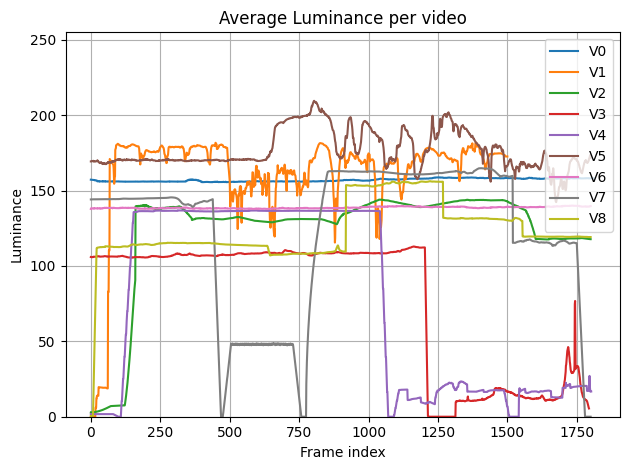

In [16]:
IMG_LUMINANCE_FILENAME = FOLDER_VIDEOS+"../VideoLuminance.jpg"

fig = plt.figure(figsize=(10,5))

# Plot with pandas
result_luminance.plot.line()

# Plot config
plt.title("Average Luminance per video")
plt.xlabel("Frame index")
plt.ylabel("Luminance")
plt.ylim([0,255])
plt.grid(True)
plt.tight_layout()

# Save
plt.savefig(IMG_LUMINANCE_FILENAME)
plt.show()

# Apply correction per participant

In [18]:
# Parameters of data to load
pid = 1         # 1-32
typ = "Behavior"  # ["Annotations", "Behavior", "Physio"]
prep = "Frame"    # ["Raw", "Transformed", "Frame"]

# Load data 
data_loaded = data_manager.load_data_from_participant(pid,typ,prep)
data_loaded

Loading from:  ../../../CEAP-360VR/4_BehaviorData\Frame\P1_Behavior_FrameData.json


,data_type,processing_level,ParticipantID,VideoID,TimeStamp,HM_Pitch,HM_Yaw,EM_Pitch,EM_Yaw,LEM_Pitch,LEM_Yaw,REM_Pitch,REM_Yaw,LPD_PD,RPD_PD
0,Behavior,Frame,1,1,0.000,1.180,1.250,0.587,-0.041,1.133,-0.417,0.040,0.335,5.580,5.580
1,Behavior,Frame,1,1,0.040,1.172,1.239,0.778,-0.035,1.492,-0.399,0.065,0.329,5.581,5.581
2,Behavior,Frame,1,1,0.080,1.158,1.167,0.810,-0.089,1.506,-0.428,0.113,0.250,5.570,5.570
3,Behavior,Frame,1,1,0.120,1.130,1.092,0.778,0.098,1.460,-0.169,0.097,0.365,5.566,5.566
4,Behavior,Frame,1,1,0.160,1.117,1.063,0.761,0.134,1.365,-0.062,0.156,0.330,5.558,5.558
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14095,Behavior,Frame,1,8,59.867,4.075,-70.649,-0.123,-81.230,-0.258,-80.945,0.011,-81.516,3.458,3.458
14096,Behavior,Frame,1,8,59.900,4.119,-70.642,-0.162,-81.209,-0.303,-80.940,-0.021,-81.477,3.456,3.456
14097,Behavior,Frame,1,8,59.933,4.141,-70.634,-0.130,-81.246,-0.289,-81.016,0.029,-81.476,3.453,3.453
14098,Behavior,Frame,1,8,59.967,4.155,-70.626,-0.175,-81.329,-0.314,-81.015,-0.036,-81.644,3.447,3.447


In [20]:
# The process below has already been implemented in the loading function
# when loading type "Behavior", level or preprocessing "Frame"
# and the parameter `clean_pd_with_luminance=True`

## NOTE: This function has an extra column called 'PD_corrected'

# Load data 
data_loaded = data_manager.load_data_from_participant(pid,typ,prep, clean_pd_with_luminance=True)
data_loaded

Loading from:  ../../../CEAP-360VR/4_BehaviorData\Frame\P1_Behavior_FrameData.json


,data_type,processing_level,ParticipantID,VideoID,TimeStamp,HM_Pitch,HM_Yaw,EM_Pitch,EM_Yaw,LEM_Pitch,LEM_Yaw,REM_Pitch,REM_Yaw,LPD_PD,RPD_PD,PD_avg,PD_corrected
0,Behavior,Frame,1,1,0.000,1.180,1.250,0.587,-0.041,1.133,-0.417,0.040,0.335,5.580,5.580,5.580,0.927266
1,Behavior,Frame,1,1,0.040,1.172,1.239,0.778,-0.035,1.492,-0.399,0.065,0.329,5.581,5.581,5.581,0.928266
2,Behavior,Frame,1,1,0.080,1.158,1.167,0.810,-0.089,1.506,-0.428,0.113,0.250,5.570,5.570,5.570,0.917266
3,Behavior,Frame,1,1,0.120,1.130,1.092,0.778,0.098,1.460,-0.169,0.097,0.365,5.566,5.566,5.566,0.913266
4,Behavior,Frame,1,1,0.160,1.117,1.063,0.761,0.134,1.365,-0.062,0.156,0.330,5.558,5.558,5.558,0.905266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14095,Behavior,Frame,1,8,59.867,4.075,-70.649,-0.123,-81.230,-0.258,-80.945,0.011,-81.516,3.458,3.458,3.458,-0.162248
14096,Behavior,Frame,1,8,59.900,4.119,-70.642,-0.162,-81.209,-0.303,-80.940,-0.021,-81.477,3.456,3.456,3.456,-0.164239
14097,Behavior,Frame,1,8,59.933,4.141,-70.634,-0.130,-81.246,-0.289,-81.016,0.029,-81.476,3.453,3.453,3.453,-0.167286
14098,Behavior,Frame,1,8,59.967,4.155,-70.626,-0.175,-81.329,-0.314,-81.015,-0.036,-81.644,3.447,3.447,3.447,-0.173276


<AxesSubplot: >

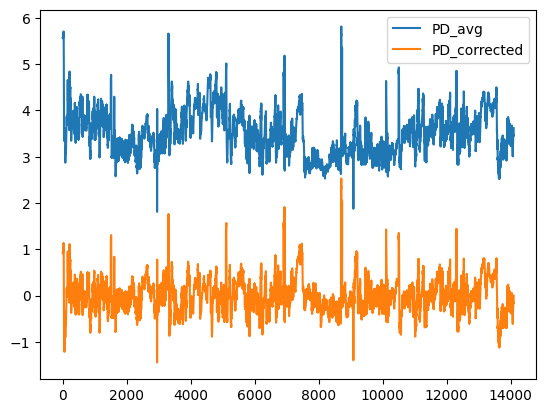

In [22]:
data_loaded[["PD_avg","PD_corrected"]].plot.line()

### Step-by-step on how the average Pupil Diameter is corrected

In [23]:
PD_cols = ["LPD_PD", "RPD_PD"]
data_loaded["PD_avg"] = data_loaded[PD_cols].mean(axis=1)
data_loaded

,data_type,processing_level,ParticipantID,VideoID,TimeStamp,HM_Pitch,HM_Yaw,EM_Pitch,EM_Yaw,LEM_Pitch,LEM_Yaw,REM_Pitch,REM_Yaw,LPD_PD,RPD_PD,PD_avg,PD_corrected
0,Behavior,Frame,1,1,0.000,1.180,1.250,0.587,-0.041,1.133,-0.417,0.040,0.335,5.580,5.580,5.580,0.927266
1,Behavior,Frame,1,1,0.040,1.172,1.239,0.778,-0.035,1.492,-0.399,0.065,0.329,5.581,5.581,5.581,0.928266
2,Behavior,Frame,1,1,0.080,1.158,1.167,0.810,-0.089,1.506,-0.428,0.113,0.250,5.570,5.570,5.570,0.917266
3,Behavior,Frame,1,1,0.120,1.130,1.092,0.778,0.098,1.460,-0.169,0.097,0.365,5.566,5.566,5.566,0.913266
4,Behavior,Frame,1,1,0.160,1.117,1.063,0.761,0.134,1.365,-0.062,0.156,0.330,5.558,5.558,5.558,0.905266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14095,Behavior,Frame,1,8,59.867,4.075,-70.649,-0.123,-81.230,-0.258,-80.945,0.011,-81.516,3.458,3.458,3.458,-0.162248
14096,Behavior,Frame,1,8,59.900,4.119,-70.642,-0.162,-81.209,-0.303,-80.940,-0.021,-81.477,3.456,3.456,3.456,-0.164239
14097,Behavior,Frame,1,8,59.933,4.141,-70.634,-0.130,-81.246,-0.289,-81.016,0.029,-81.476,3.453,3.453,3.453,-0.167286
14098,Behavior,Frame,1,8,59.967,4.155,-70.626,-0.175,-81.329,-0.314,-81.015,-0.036,-81.644,3.447,3.447,3.447,-0.173276


In [24]:
videos_ids = data_loaded["VideoID"].unique()
videos_ids_str = [ f"V{i}" for i in videos_ids ]
print(videos_ids)
print(videos_ids_str)

[1 2 3 4 5 6 7 8]
['V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8']


Apply pupil correction

In [25]:
def estimate_pupil_response_caused_by_luminance(pupil_response:np.array, luminance:np.array):
    """
    Returns an array with the estimated pupil diameter response
    dependent on the luminance changes in a video.

    Based on discussion in section 4 from DOI: 10.1155/2020/2909267
    Eye-Tracking Analysis for Emotion Recognition
    """

    y = pupil_response
    x = luminance

    min_samples = np.min([y.size, x.size])
    y = y[:min_samples]
    x = x[:min_samples]

    # Arrange dimensions
    if x.ndim == 1:
        x = np.ones( (luminance.size, 2) )
        x[:,0] = luminance

    if y.ndim == 1:
        y = y.reshape(-1,1)

    # Solution of linear model
    y_solution = np.linalg.lstsq(x, y, rcond=None)

    # Calculate PD given the luminance
    coeffs = y_solution[0]  # Coefficients (b0, b1,...)

    # Estimated pupil diameter given the luminance
    y_est = np.matmul(x, coeffs)

    return y_est


In [26]:
# CONSTANTS FOR PUPIL ANALYSIS

PD_AVG_COLNAME = "PD_avg"
PD_FROM_LUMINANCE_COLNAME = "PD_est"
PD_RESIDUAL_COLNAME = "PD_corrected"

In [27]:
### VIDEO SELECTION
i = 2 # Index in the arrays above

VIDEO_LUMINANCE_COLNAME = videos_ids_str[i]

df_pd_participant_in_video = data_loaded.loc[ (data_loaded["VideoID"] == videos_ids[i]), PD_AVG_COLNAME ]
df_pd_participant_in_video = df_pd_participant_in_video.reset_index().drop(["index"],axis=1)
print(f"{videos_ids_str[i]} {df_pd_participant_in_video.shape} {df_pd_participant_in_video.isna().sum()}")

df_luminance_in_video = result_luminance[ VIDEO_LUMINANCE_COLNAME ].dropna()
print(f"\t {df_luminance_in_video.shape} \n{df_luminance_in_video.isna().sum()}")

###### Match both to the minimum samples
df_pd_combined = pd.merge(df_pd_participant_in_video, df_luminance_in_video, left_index=True, right_index=True, how="left")
df_pd_combined = df_pd_combined.fillna(method="ffill") # In case there are few missing values vs. what was writtenin VideoInfo.json
print(f"\n {df_pd_combined.shape} \n{df_pd_combined.isna().sum()}")


V3 (1800, 1) PD_avg    0
dtype: int64
	 (1795,) 
0

 (1800, 2) 
PD_avg    0
V3        0
dtype: int64


In [28]:
# Estimate the linear relationship due to luminance
est_pupil_response = estimate_pupil_response_caused_by_luminance(df_pd_combined[ PD_AVG_COLNAME ].values, df_pd_combined[ VIDEO_LUMINANCE_COLNAME ].values)
df_pd_adjusted = pd.DataFrame(data=est_pupil_response, columns=[ PD_FROM_LUMINANCE_COLNAME ])
df_pd_combined = df_pd_combined.join(df_pd_adjusted)

# Residual response not caused by videos' luminance
df_pd_combined[ PD_RESIDUAL_COLNAME ] = df_pd_combined[ PD_AVG_COLNAME ] - df_pd_combined[ PD_FROM_LUMINANCE_COLNAME ]


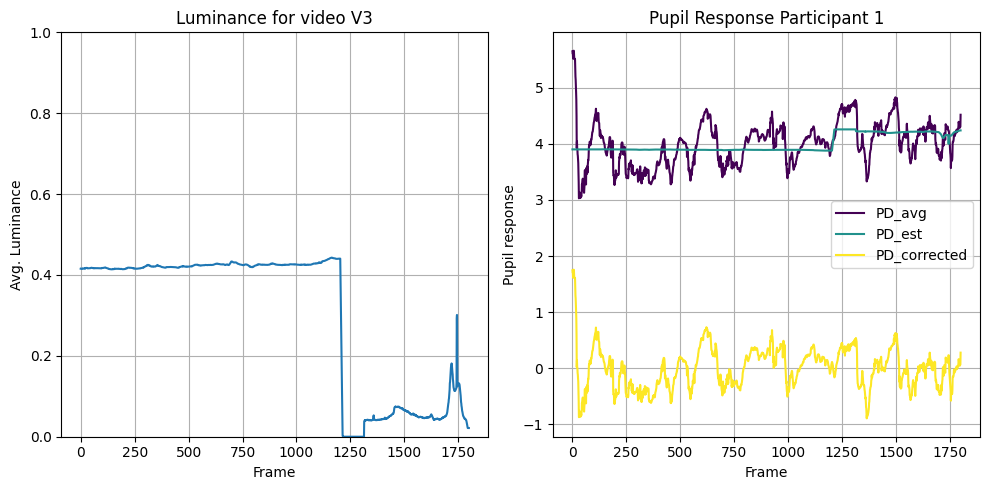

In [29]:
######### Plot
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

ax = axes[0]
df_plot_luminance = df_pd_combined[ VIDEO_LUMINANCE_COLNAME ]/255
df_plot_luminance.plot.line(ax=ax)
ax.set(ylim=[0,1])
ax.set(xlabel="Frame", ylabel="Avg. Luminance")
ax.set(title=f"Luminance for video {videos_ids_str[i]}")
ax.grid(True)

ax = axes[1]
df_plot_pd = df_pd_combined.drop([ VIDEO_LUMINANCE_COLNAME ], axis=1)
df_plot_pd.plot.line(ax=ax, cmap="viridis")
df_plot_pd.columns = ["PD recorded","PD estimated from luminance", "PD after removing luminance effect"]
ax.set(xlabel="Frame", ylabel="Pupil response")
ax.set(title=f"Pupil Response Participant {pid}")
ax.grid(True)

plt.tight_layout()
plt.show()

In [30]:
## Apply across all videos
for i,v in enumerate(videos_ids):
    VIDEO_LUMINANCE_COLNAME = videos_ids_str[i]

    df_pd_participant_in_video = data_loaded.loc[ (data_loaded["VideoID"] == videos_ids[i]), PD_AVG_COLNAME ]
    df_pd_participant_in_video = df_pd_participant_in_video.reset_index().drop(["index"],axis=1)
    print(f"{videos_ids_str[i]} {df_pd_participant_in_video.shape} {df_pd_participant_in_video.isna().sum()}")

    df_luminance_in_video = result_luminance[ VIDEO_LUMINANCE_COLNAME ].dropna()
    print(f"{videos_ids_str[i]} {df_luminance_in_video.shape} {df_luminance_in_video.isna().sum()}")

    ###### Match both to the minimum samples
    df_pd_combined = pd.merge(df_pd_participant_in_video, df_luminance_in_video, left_index=True, right_index=True, how="left")
    df_pd_combined = df_pd_combined.fillna(method="ffill") # In case there are few missing values vs. what was writtenin VideoInfo.json

    # Estimate the linear relationship due to luminance
    est_pupil_response = estimate_pupil_response_caused_by_luminance(df_pd_combined[ PD_AVG_COLNAME ].values, df_pd_combined[ VIDEO_LUMINANCE_COLNAME ].values)
    df_pd_adjusted = pd.DataFrame(data=est_pupil_response, columns=[ PD_FROM_LUMINANCE_COLNAME ])
    df_pd_combined = df_pd_combined.join(df_pd_adjusted)

    # Residual response not caused by videos' luminance
    df_pd_combined[ PD_RESIDUAL_COLNAME ] = df_pd_combined[ PD_AVG_COLNAME ] - df_pd_combined[ PD_FROM_LUMINANCE_COLNAME ]

    ### Add to final data
    data_loaded.loc[ data_loaded["VideoID"]==v, "PD_corrected_manual" ] = df_pd_combined[PD_RESIDUAL_COLNAME].values

V1 (1500, 1) PD_avg    0
dtype: int64
V1 (1501,) 0
V2 (1800, 1) PD_avg    0
dtype: int64
V2 (1801,) 0
V3 (1800, 1) PD_avg    0
dtype: int64
V3 (1795,) 0
V4 (1800, 1) PD_avg    0
dtype: int64
V4 (1803,) 0
V5 (1800, 1) PD_avg    0
dtype: int64
V5 (1801,) 0
V6 (1800, 1) PD_avg    0
dtype: int64
V6 (1801,) 0
V7 (1800, 1) PD_avg    0
dtype: int64
V7 (1801,) 0
V8 (1800, 1) PD_avg    0
dtype: int64
V8 (1801,) 0


<AxesSubplot: >

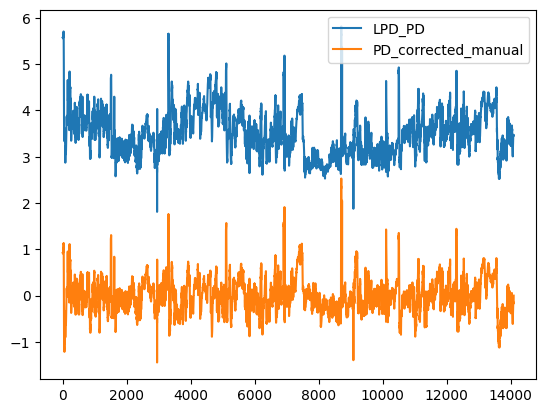

In [31]:
data_loaded[["LPD_PD","PD_corrected_manual"]].plot.line()

In [32]:
print('End of notebook')

End of notebook
